In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection, preprocessing, pipeline
import torch
from torch import nn, optim, utils

# Preliminaries

## Define some utility functions

In [2]:
def clip_gradients_(
    clip_grad_strategy,
    model_fn,
    clip_value=None,
    error_if_nonfinite=False,
    max_norm=None,
    norm_type=2.0):
    if clip_grad_strategy == "value" and clip_value is not None:
        nn.utils.clip_grad_value_(
            model_fn.parameters(),
            clip_value
        )
    elif clip_grad_strategy == "norm" and max_norm is not None:
        nn.utils.clip_grad_norm_(
            model_fn.parameters(),
            max_norm,
            norm_type,
            error_if_nonfinite
        )
    elif clip_grad_strategy is None:
        pass
    else:
        raise NotImplementedError()


def compute_average_loss(dataloader, loss_fn, model_fn):
    total_loss = torch.zeros(1, 1)
    for features, targets in dataloader:
        predictions = model_fn(features)        
        total_loss += loss_fn(predictions, targets)
    average_loss = total_loss / len(dataloader)
    return average_loss


def initialize_linear_layer(
    in_features,
    out_features,
    init_strategy_=nn.init.kaiming_uniform_):
    linear_layer = nn.Linear(in_features, out_features)
    init_strategy_(linear_layer.weight)
    return linear_layer


def make_mlp_classifier(
    input_size,
    hidden_sizes=None,
    output_size=2,
    activation_fn=None,
    init_strategy_=nn.init.kaiming_uniform_,
    batch_normalization=False):
    modules = []
    hidden_sizes = [] if hidden_sizes is None else hidden_sizes
    for hidden_size in hidden_sizes:
        hidden_layer = initialize_linear_layer(
            input_size,
            hidden_size,
            init_strategy_,
        )
        modules.append(hidden_layer)
        if batch_normalization:
            modules.append(nn.BatchNorm1d(hidden_size))
        if activation_fn is not None:
            modules.append(activation_fn)
        input_size=hidden_size
    output_layer = initialize_linear_layer(
            input_size,
            output_size,
            init_strategy_,
    )
    modules.append(output_layer)
    modules.append(nn.LogSoftmax(dim=1))
    model_fn = nn.Sequential(*modules)
    return model_fn, nn.NLLLoss()


## Define our training loop

In [3]:
def fit(
    loss_fn,
    model_fn,
    optimizer,
    train_dataloader,
    val_dataloader,
    clip_grad_strategy=None,
    clip_value=None,
    error_if_nonfinite=False,
    log_epochs=1,
    max_epochs=1,
    max_norm=None,
    norm_type=2.0):
  
    history = {
        "epoch": [],
        "average_train_loss": [],
        "average_val_loss": []
    }

    for epoch in range(max_epochs):
        total_train_loss = torch.zeros(1, 1)
        model_fn = model_fn.train()
        for features, targets in train_dataloader:
            
            # forward pass
            predictions = model_fn(features)        
            loss = loss_fn(predictions, targets)
            total_train_loss += loss

            # backward pass
            loss.backward()
            clip_gradients_(
                clip_grad_strategy,
                model_fn,
                clip_value,
                error_if_nonfinite,
                max_norm,
                norm_type
            )
            optimizer.step()        
            optimizer.zero_grad()
        
        average_train_loss = total_train_loss / len(train_dataloader)
        history["epoch"].append(epoch)
        history["average_train_loss"].append(average_train_loss.item())

        # validation after every training epoch
        model_fn = model_fn.eval()
        with torch.inference_mode():
            average_val_loss = compute_average_loss(
                val_dataloader,
                loss_fn,
                model_fn
            )
        history["average_val_loss"].append(average_val_loss.item())


        if epoch % log_epochs == 0:
            message = f"Epoch {epoch}, Average train Loss {average_train_loss.item():.4f}, Average val Loss {average_val_loss.item():.4f}"
            print(message)

    history_df = (pd.DataFrame.from_dict(history)
                              .set_index("epoch"))
    return history_df


## Load the Data

In [4]:
INPUT_SIZE = 784
OUTPUT_SIZE = 10

_train_data = pd.read_csv(
    "./sample_data/mnist_train_small.csv",
    header=None,
    names=["label"] + [f"p{i}" for i in range(INPUT_SIZE)],
)
train_data, val_data = model_selection.train_test_split(
    _train_data,
    test_size=0.1,
    stratify=_train_data.loc[:, "label"]
)

test_data = pd.read_csv(
    "./sample_data/mnist_test.csv",
    header=None,
    names=["label"] + [f"p{i}" for i in range(INPUT_SIZE)],
)


In [5]:
features_preprocessor = pipeline.make_pipeline(
    preprocessing.MinMaxScaler(),
    preprocessing.FunctionTransformer(lambda arr: arr.astype(np.float32)),
    preprocessing.FunctionTransformer(lambda arr: torch.from_numpy(arr))
)

target_preprocessor = pipeline.make_pipeline(
    preprocessing.FunctionTransformer(lambda df: df.to_numpy()),
    preprocessing.FunctionTransformer(lambda arr: torch.from_numpy(arr))
)


In [6]:
BATCH_SIZE = 64
NUM_WORKERS = 2

# create the training dataset and dataloader
train_features_tensor = features_preprocessor.fit_transform(
    train_data.drop("label", axis=1)
)

train_target_tensor = target_preprocessor.fit_transform(
    train_data.loc[:, "label"]
)

train_dataset = utils.data.TensorDataset(
    train_features_tensor,
    train_target_tensor
)

train_dataloader = utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

# create the validation dataset and dataloader
val_features_tensor = features_preprocessor.transform(
    val_data.drop("label", axis=1)
)

val_target_tensor = target_preprocessor.transform(
    val_data.loc[:, "label"]
)

val_dataset = utils.data.TensorDataset(
    val_features_tensor,
    val_target_tensor
)

val_dataloader = utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

# create the test dataset and dataloader
test_features_tensor = features_preprocessor.transform(
    test_data.drop("label", axis=1)
)

test_target_tensor = target_preprocessor.transform(
    test_data.loc[:, "label"]
)

test_dataset = utils.data.TensorDataset(
    test_features_tensor,
    test_target_tensor
)

test_dataloader = utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)


# Faster Optimizers


## SGD

In [56]:
optim.SGD?

In [7]:
HIDDEN_SIZE = 100
LEARNING_RATE = 1e-2
MAX_EPOCHS = 20

model_fn, loss_fn = make_mlp_classifier(
    input_size=INPUT_SIZE, 
    hidden_sizes=[HIDDEN_SIZE, HIDDEN_SIZE, HIDDEN_SIZE], 
    output_size=OUTPUT_SIZE, 
    activation_fn=nn.SELU(),
    init_strategy_=nn.init.xavier_normal_
)

optimizer = optim.SGD(model_fn.parameters(), lr=LEARNING_RATE)

history = fit(
    loss_fn,
    model_fn,
    optimizer,
    train_dataloader,
    val_dataloader,
    max_epochs=MAX_EPOCHS
)

Epoch 0, Average train Loss 0.8173, Average val Loss 0.5126
Epoch 1, Average train Loss 0.4201, Average val Loss 0.4069
Epoch 2, Average train Loss 0.3546, Average val Loss 0.3620
Epoch 3, Average train Loss 0.3216, Average val Loss 0.3357
Epoch 4, Average train Loss 0.3002, Average val Loss 0.3185
Epoch 5, Average train Loss 0.2841, Average val Loss 0.3061
Epoch 6, Average train Loss 0.2710, Average val Loss 0.2958
Epoch 7, Average train Loss 0.2599, Average val Loss 0.2871
Epoch 8, Average train Loss 0.2500, Average val Loss 0.2796
Epoch 9, Average train Loss 0.2410, Average val Loss 0.2729
Epoch 10, Average train Loss 0.2328, Average val Loss 0.2669
Epoch 11, Average train Loss 0.2250, Average val Loss 0.2615
Epoch 12, Average train Loss 0.2176, Average val Loss 0.2562
Epoch 13, Average train Loss 0.2106, Average val Loss 0.2512
Epoch 14, Average train Loss 0.2038, Average val Loss 0.2463
Epoch 15, Average train Loss 0.1973, Average val Loss 0.2418
Epoch 16, Average train Loss 0.191

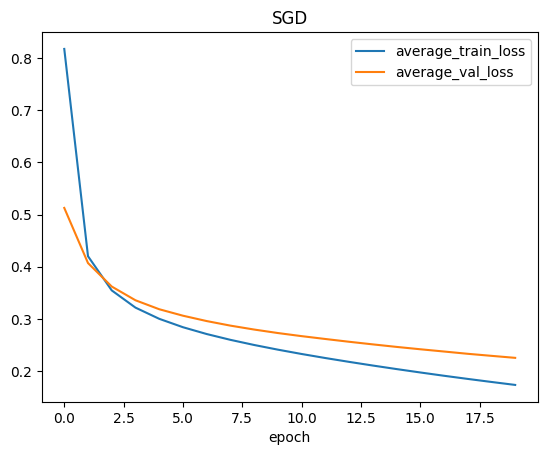

In [8]:
_ = history.plot(title="SGD")

## Momentum

In [9]:
model_fn, loss_fn = make_mlp_classifier(
    input_size=INPUT_SIZE, 
    hidden_sizes=[HIDDEN_SIZE, HIDDEN_SIZE, HIDDEN_SIZE], 
    output_size=OUTPUT_SIZE, 
    activation_fn=nn.SELU(),
    init_strategy_=nn.init.xavier_normal_
)

optimizer = optim.SGD(
    model_fn.parameters(),
    lr=LEARNING_RATE,
    momentum=0.9,
    dampening=0.0,
)

history = fit(
    loss_fn,
    model_fn,
    optimizer,
    train_dataloader,
    val_dataloader,
    max_epochs=MAX_EPOCHS
)

Epoch 0, Average train Loss 0.4533, Average val Loss 0.3097
Epoch 1, Average train Loss 0.2614, Average val Loss 0.2407
Epoch 2, Average train Loss 0.2009, Average val Loss 0.2043
Epoch 3, Average train Loss 0.1604, Average val Loss 0.1847
Epoch 4, Average train Loss 0.1308, Average val Loss 0.1739
Epoch 5, Average train Loss 0.1081, Average val Loss 0.1666
Epoch 6, Average train Loss 0.0901, Average val Loss 0.1624
Epoch 7, Average train Loss 0.0760, Average val Loss 0.1628
Epoch 8, Average train Loss 0.0642, Average val Loss 0.1665
Epoch 9, Average train Loss 0.0539, Average val Loss 0.1706
Epoch 10, Average train Loss 0.0446, Average val Loss 0.1731
Epoch 11, Average train Loss 0.0370, Average val Loss 0.1742
Epoch 12, Average train Loss 0.0305, Average val Loss 0.1863
Epoch 13, Average train Loss 0.0245, Average val Loss 0.1862
Epoch 14, Average train Loss 0.0202, Average val Loss 0.1835
Epoch 15, Average train Loss 0.0167, Average val Loss 0.1767
Epoch 16, Average train Loss 0.013

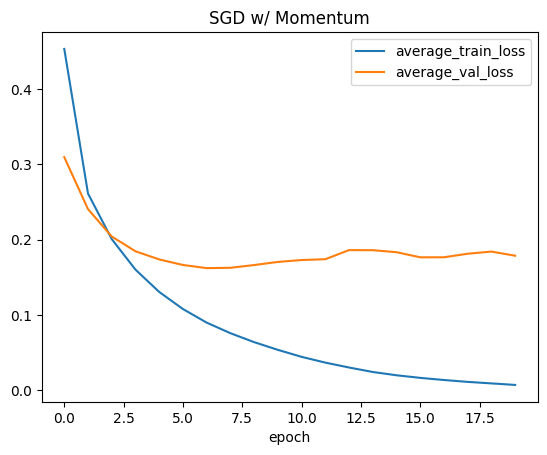

In [10]:
_ = history.plot(title="SGD w/ Momentum")

## Momentum with Nesterov Accelerated Gradient

In [11]:
model_fn, loss_fn = make_mlp_classifier(
    input_size=INPUT_SIZE, 
    hidden_sizes=[HIDDEN_SIZE, HIDDEN_SIZE, HIDDEN_SIZE], 
    output_size=OUTPUT_SIZE, 
    activation_fn=nn.SELU(),
    init_strategy_=nn.init.xavier_normal_
)

optimizer = optim.SGD(
    model_fn.parameters(),
    lr=LEARNING_RATE,
    momentum=0.9,
    dampening=0,
    nesterov=True,
)

history = fit(
    loss_fn,
    model_fn,
    optimizer,
    train_dataloader,
    val_dataloader,
    max_epochs=MAX_EPOCHS
)

Epoch 0, Average train Loss 0.4335, Average val Loss 0.3047
Epoch 1, Average train Loss 0.2494, Average val Loss 0.2304
Epoch 2, Average train Loss 0.1928, Average val Loss 0.1973
Epoch 3, Average train Loss 0.1561, Average val Loss 0.1776
Epoch 4, Average train Loss 0.1290, Average val Loss 0.1649
Epoch 5, Average train Loss 0.1070, Average val Loss 0.1575
Epoch 6, Average train Loss 0.0895, Average val Loss 0.1550
Epoch 7, Average train Loss 0.0751, Average val Loss 0.1562
Epoch 8, Average train Loss 0.0628, Average val Loss 0.1585
Epoch 9, Average train Loss 0.0525, Average val Loss 0.1625
Epoch 10, Average train Loss 0.0438, Average val Loss 0.1649
Epoch 11, Average train Loss 0.0362, Average val Loss 0.1652
Epoch 12, Average train Loss 0.0298, Average val Loss 0.1677
Epoch 13, Average train Loss 0.0248, Average val Loss 0.1724
Epoch 14, Average train Loss 0.0208, Average val Loss 0.1753
Epoch 15, Average train Loss 0.0173, Average val Loss 0.1798
Epoch 16, Average train Loss 0.014

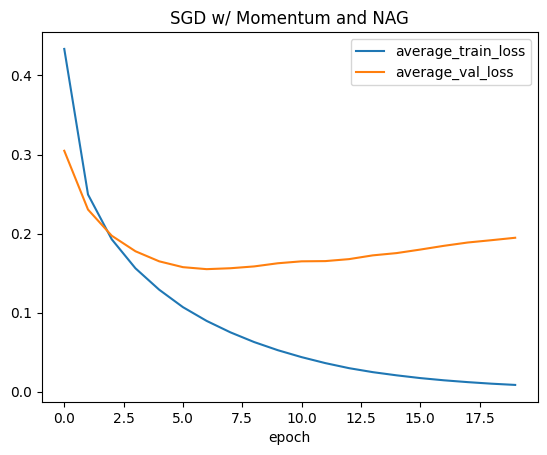

In [12]:
_ = history.plot(title="SGD w/ Momentum and NAG")

### Exercise

Re-train your model for different values of momentum both with and without NAG. What is the best combination of these hyperparameters that you can find?

## AdaGrad

In [104]:
optim.Adagrad?

In [13]:
model_fn, loss_fn = make_mlp_classifier(
    input_size=INPUT_SIZE, 
    hidden_sizes=[HIDDEN_SIZE, HIDDEN_SIZE, HIDDEN_SIZE], 
    output_size=OUTPUT_SIZE, 
    activation_fn=nn.SELU(),
    init_strategy_=nn.init.xavier_normal_
)

optimizer = optim.Adagrad(
    model_fn.parameters(),
    lr=LEARNING_RATE,
    lr_decay=0.0,
)

history = fit(
    loss_fn,
    model_fn,
    optimizer,
    train_dataloader,
    val_dataloader,
    max_epochs=MAX_EPOCHS
)

Epoch 0, Average train Loss 0.4328, Average val Loss 0.4814
Epoch 1, Average train Loss 0.2359, Average val Loss 0.2665
Epoch 2, Average train Loss 0.1924, Average val Loss 0.2215
Epoch 3, Average train Loss 0.1639, Average val Loss 0.2001
Epoch 4, Average train Loss 0.1435, Average val Loss 0.1863
Epoch 5, Average train Loss 0.1277, Average val Loss 0.1775
Epoch 6, Average train Loss 0.1150, Average val Loss 0.1708
Epoch 7, Average train Loss 0.1044, Average val Loss 0.1655
Epoch 8, Average train Loss 0.0953, Average val Loss 0.1616
Epoch 9, Average train Loss 0.0875, Average val Loss 0.1579
Epoch 10, Average train Loss 0.0805, Average val Loss 0.1550
Epoch 11, Average train Loss 0.0744, Average val Loss 0.1526
Epoch 12, Average train Loss 0.0689, Average val Loss 0.1508
Epoch 13, Average train Loss 0.0640, Average val Loss 0.1494
Epoch 14, Average train Loss 0.0595, Average val Loss 0.1482
Epoch 15, Average train Loss 0.0554, Average val Loss 0.1474
Epoch 16, Average train Loss 0.051

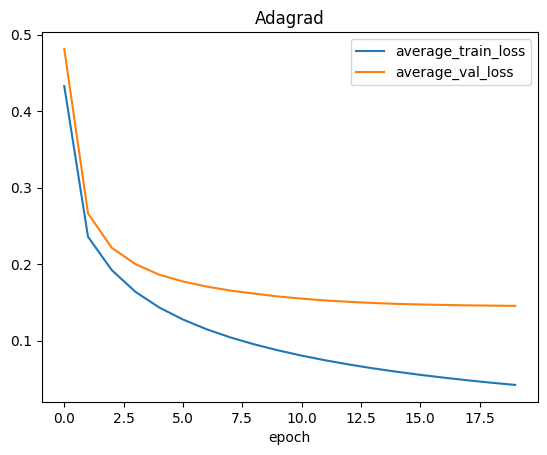

In [14]:
_ = history.plot(title="Adagrad")

## Adam

In [107]:
optim.Adam?

In [15]:
model_fn, loss_fn = make_mlp_classifier(
    input_size=INPUT_SIZE, 
    hidden_sizes=[HIDDEN_SIZE, HIDDEN_SIZE, HIDDEN_SIZE], 
    output_size=OUTPUT_SIZE, 
    activation_fn=nn.SELU(),
    init_strategy_=nn.init.xavier_normal_
)

optimizer = optim.Adam(
    model_fn.parameters(),
    lr=LEARNING_RATE,
    betas=(0.9, 0.999),
    amsgrad=False,
)

history = fit(
    loss_fn,
    model_fn,
    optimizer,
    train_dataloader,
    val_dataloader,
    max_epochs=MAX_EPOCHS
)

Epoch 0, Average train Loss 0.5194, Average val Loss 0.4311
Epoch 1, Average train Loss 0.2990, Average val Loss 0.2857
Epoch 2, Average train Loss 0.2652, Average val Loss 0.4164
Epoch 3, Average train Loss 0.2325, Average val Loss 0.2865
Epoch 4, Average train Loss 0.2485, Average val Loss 0.5401
Epoch 5, Average train Loss 0.2094, Average val Loss 0.4528
Epoch 6, Average train Loss 0.1865, Average val Loss 0.4095
Epoch 7, Average train Loss 0.1729, Average val Loss 0.3483
Epoch 8, Average train Loss 0.2018, Average val Loss 0.5326
Epoch 9, Average train Loss 0.1883, Average val Loss 0.2739
Epoch 10, Average train Loss 0.1881, Average val Loss 0.3816
Epoch 11, Average train Loss 0.1605, Average val Loss 0.3705
Epoch 12, Average train Loss 0.1313, Average val Loss 0.3828
Epoch 13, Average train Loss 0.1826, Average val Loss 0.4278
Epoch 14, Average train Loss 0.1135, Average val Loss 0.3951
Epoch 15, Average train Loss 0.0957, Average val Loss 0.4871
Epoch 16, Average train Loss 0.525

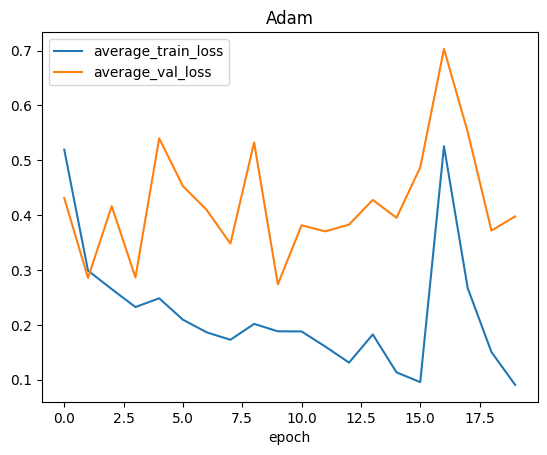

In [16]:
_ = history.plot(title="Adam")

## Adam variants: Adamax, Nadam, AdamW

In [ ]:
optim.Adamax?

In [ ]:
optim.NAdam?

In [110]:
optim.AdamW?

Epoch 0, Average train Loss 0.4948, Average val Loss 0.3403
Epoch 1, Average train Loss 0.2697, Average val Loss 0.2931
Epoch 2, Average train Loss 0.2583, Average val Loss 0.3328
Epoch 3, Average train Loss 0.2572, Average val Loss 0.3273
Epoch 4, Average train Loss 0.2127, Average val Loss 0.2790
Epoch 5, Average train Loss 0.2059, Average val Loss 0.2438
Epoch 6, Average train Loss 0.2175, Average val Loss 0.3713
Epoch 7, Average train Loss 0.1817, Average val Loss 0.3862
Epoch 8, Average train Loss 0.1597, Average val Loss 0.2959
Epoch 9, Average train Loss 0.1700, Average val Loss 0.3250
Epoch 10, Average train Loss 0.1634, Average val Loss 0.2640
Epoch 11, Average train Loss 0.1173, Average val Loss 0.3418
Epoch 12, Average train Loss 0.1548, Average val Loss 0.3390
Epoch 13, Average train Loss 0.1477, Average val Loss 0.2900
Epoch 14, Average train Loss 0.1465, Average val Loss 0.4295
Epoch 15, Average train Loss 0.1896, Average val Loss 0.4388
Epoch 16, Average train Loss 0.112

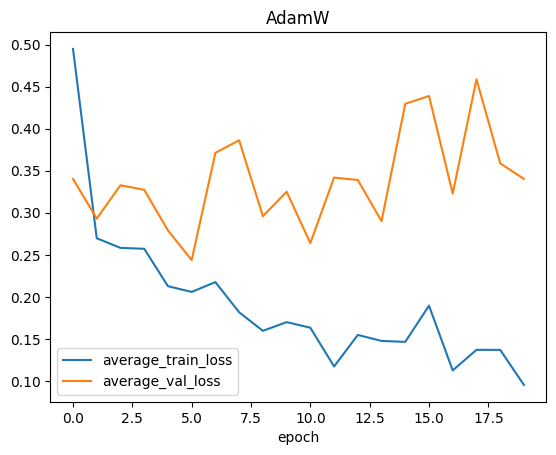

In [17]:
model_fn, loss_fn = make_mlp_classifier(
    input_size=INPUT_SIZE, 
    hidden_sizes=[HIDDEN_SIZE, HIDDEN_SIZE, HIDDEN_SIZE], 
    output_size=OUTPUT_SIZE, 
    activation_fn=nn.SELU(),
    init_strategy_=nn.init.xavier_normal_
)

optimizer = optim.AdamW(
    model_fn.parameters(),
    lr=LEARNING_RATE,
    betas=(0.9, 0.999),
    amsgrad=False,
)

history = fit(
    loss_fn,
    model_fn,
    optimizer,
    train_dataloader,
    val_dataloader,
    max_epochs=MAX_EPOCHS
)

_ = history.plot(title="AdamW")

## Exercise:

Create a MLP with three hidden layers, each with 100 neurons per layer, and train it for 10 epochs using the following optimizers. 

1. Adam
2. Adamax
3. NAdam
4. AdamW

Plot the training and validation loss curves. Compare and contrast.